In [ ]:
import pandas as pd
from binance.client import Client
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier



In [18]:
def get_data(api_key = 'your_api_key', api_secret = 'your_api_secret', symbol = 'BTCUSDT', interval = '1d', start_date = '1 Jan, 2010', end_date = '28 Feb, 2025'):
    client = Client(api_key, api_secret)
    klines = client.get_historical_klines(symbol, interval, start_date, end_date)
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df.set_index('timestamp', inplace=True)
    return df[['open', 'close', 'volume']]

btc = get_data()
btc.head()

,open,close,volume
timestamp,,,
2017-08-17,4261.48000000,4285.08000000,795.15037700
2017-08-18,4285.08000000,4108.37000000,1199.88826400
2017-08-19,4108.37000000,4139.98000000,381.30976300
2017-08-20,4120.98000000,4086.29000000,467.08302200
2017-08-21,4069.13000000,4016.00000000,691.74306000


In [19]:
for col in btc.columns:
    btc[col] = pd.to_numeric(btc[col])
btc['return'] = np.log(btc['close'] / btc['close'].shift(1))
btc['volatility'] = btc['return'].rolling(7).std()

btc.head(10)

,open,close,volume,return,volatility
timestamp,,,,,
2017-08-17,4261.48,4285.08,795.150377,NaN,NaN
2017-08-18,4285.08,4108.37,1199.888264,-0.042113,NaN
2017-08-19,4108.37,4139.98,381.309763,0.007665,NaN
2017-08-20,4120.98,4086.29,467.083022,-0.013053,NaN
2017-08-21,4069.13,4016.00,691.743060,-0.017351,NaN
2017-08-22,4016.00,4040.00,966.684858,0.005958,NaN
2017-08-23,4040.00,4114.01,1001.136565,0.018154,NaN
2017-08-24,4147.00,4316.01,787.418753,0.047933,0.028749
2017-08-25,4316.01,4280.68,573.612740,-0.008219,0.022432


In [20]:
back_test_day = 10
for _ in range(1, back_test_day + 1):
    btc[f'close_{_}'] = btc['close'].shift(_)
    btc[f'volume_{_}'] = btc['volume'].shift(_)
    btc[f'volatility_{_}'] = btc['volatility'].shift(_)

btc['day'] = range(1, len(btc) + 1)

btc['result'] = (btc['close'] / btc['open']).apply(lambda x: 1 if x > 1 else 0)
#btc['result'] = (btc['close'].astype(float) / btc['open'].astype(float)).apply(lambda x: 1 if x < 0.998 else 0)

btc_cleaned = btc.dropna()
btc_cleaned.head(-10)

,open,close,volume,return,volatility,close_1,volume_1,volatility_1,close_2,volume_2,...,volume_8,volatility_8,close_9,volume_9,volatility_9,close_10,volume_10,volatility_10,day,result
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-09-03,4508.50,4509.08,691.216198,0.008226,0.041013,4472.14,929.148595,0.041277,4834.91,560.666366,...,228.108068,0.022602,4280.68,573.612740,0.022432,4316.01,787.418753,0.028749,18,1
2017-09-04,4505.00,4100.11,1394.644614,-0.095079,0.055469,4509.08,691.216198,0.041013,4472.14,929.148595,...,350.692585,0.021753,4337.44,228.108068,0.022602,4280.68,573.612740,0.022432,19,0
2017-09-05,4106.97,4366.47,1228.938157,0.062941,0.058769,4100.11,1394.644614,0.055469,4509.08,691.216198,...,603.841616,0.018892,4310.01,350.692585,0.021753,4337.44,228.108068,0.022602,20,1
2017-09-06,4366.49,4619.77,807.363726,0.056390,0.063473,4366.47,1228.938157,0.058769,4100.11,1394.644614,...,603.545028,0.022043,4386.69,603.841616,0.018892,4310.01,350.692585,0.021753,21,1
2017-09-07,4619.77,4691.61,500.429975,0.015431,0.062039,4619.77,807.363726,0.063473,4366.47,1228.938157,...,808.468771,0.024017,4587.48,603.545028,0.022043,4386.69,603.841616,0.018892,22,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-14,96608.13,97500.48,18173.026460,0.009194,0.013525,96608.14,19921.776160,0.013091,97869.99,29151.166250,...,23515.204050,0.024116,96612.43,26233.304440,0.025163,97763.13,40267.986970,0.028119,2739,1
2025-02-15,97500.47,97569.66,7349.376830,0.000709,0.013499,97500.48,18173.026460,0.013525,96608.14,19921.776160,...,31794.220650,0.023926,96554.35,23515.204050,0.024116,96612.43,26233.304440,0.025163,2740,1
2025-02-16,97569.67,96118.12,8191.424900,-0.014989,0.014919,97569.66,7349.376830,0.013499,97500.48,18173.026460,...,10147.242940,0.023704,96506.80,31794.220650,0.023926,96554.35,23515.204050,0.024116,2741,0


In [21]:
# Calculate the indices for splitting the data
train_size = int(len(btc) * 0.6)
validate_size = int(len(btc) * 0.2)

# Split the data
train = btc[:train_size]
validate = btc[train_size:train_size + validate_size]
test = btc[train_size + validate_size:]

# Define the columns for train_x and train_y
x_columns = [f'close_{i}' for i in range(1, back_test_day + 1)] + ['day'] + [f'volume_{i}' for i in range(1, back_test_day + 1)] + [f'volatility_{i}' for i in range(1, back_test_day + 1)]
y_column = 'result'

# Separate train_x and train_y
train_x = train[x_columns]
train_y = train[y_column]

# Separate validate_x and validate_y
validate_x = validate[x_columns]
validate_y = validate[y_column]

# Separate test_x and test_y
test_x = test[x_columns]
test_y = test[y_column]

train_x.info()
train_y.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1651 entries, 2017-08-17 to 2022-02-22
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close_1        1650 non-null   float64
 1   close_2        1649 non-null   float64
 2   close_3        1648 non-null   float64
 3   close_4        1647 non-null   float64
 4   close_5        1646 non-null   float64
 5   close_6        1645 non-null   float64
 6   close_7        1644 non-null   float64
 7   close_8        1643 non-null   float64
 8   close_9        1642 non-null   float64
 9   close_10       1641 non-null   float64
 10  day            1651 non-null   int64  
 11  volume_1       1650 non-null   float64
 12  volume_2       1649 non-null   float64
 13  volume_3       1648 non-null   float64
 14  volume_4       1647 non-null   float64
 15  volume_5       1646 non-null   float64
 16  volume_6       1645 non-null   float64
 17  volume_7       1644 non-null   flo

In [ ]:
imputer = SimpleImputer(strategy='mean')
train_x_imputed = imputer.fit_transform(train_x)
validate_x_imputed = imputer.transform(validate_x)

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Fit the model
log_reg.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred = log_reg.predict(train_x_imputed)

# Calculate the accuracy
accuracy = accuracy_score(train_y, train_y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.5390672319806178


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# Initialize the KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Fit the model
knn.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred_knn = knn.predict(train_x_imputed)

# Calculate the accuracy
accuracy_knn = accuracy_score(train_y, train_y_pred_knn)
print(f'KNN Accuracy: {accuracy_knn}')

KNN Accuracy: 0.6874621441550576


In [24]:
# Initialize the Random Forest Classifier with reduced number of estimators, limited max depth, and class weights
rf_classifier = RandomForestClassifier(n_estimators=20, max_depth=5, random_state=42)

# Fit the model
rf_classifier.fit(train_x, train_y)

# Predict on the training data
train_y_pred_rf = rf_classifier.predict(train_x)

# Calculate the accuracy
accuracy = accuracy_score(train_y, train_y_pred_rf)
print(f'Accuracy: {accuracy}')

Accuracy: 0.711084191399152


In [25]:

# Initialize the Decision Tree model
dt_classifier = DecisionTreeClassifier(random_state=42)

# Fit the model
dt_classifier.fit(train_x, train_y)

# Predict on the training data
train_y_pred_dt = dt_classifier.predict(train_x_imputed)

# Calculate the accuracy
accuracy_dt = accuracy_score(train_y, train_y_pred_dt)
print(f'Decision Tree Accuracy: {accuracy_dt}')

# Predict on the validation data
validate_y_pred_dt = dt_classifier.predict(validate_x)

# Calculate the accuracy on the validation data
accuracy_validate_dt = accuracy_score(validate_y, validate_y_pred_dt)
print(f'Decision Tree Validation Accuracy: {accuracy_validate_dt}')

Decision Tree Accuracy: 0.9957601453664445
Decision Tree Validation Accuracy: 0.5290909090909091


c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Initialize the Gradient Boosting model
gb_classifier = GradientBoostingClassifier(random_state=42)

# Fit the model
gb_classifier.fit(train_x_imputed, train_y)

# Predict on the training data
train_y_pred_gb = gb_classifier.predict(train_x_imputed)

# Calculate the accuracy on the training data
accuracy_gb_train = accuracy_score(train_y, train_y_pred_gb)
print(f'Gradient Boosting Training Accuracy: {accuracy_gb_train}')

# Predict on the validation data
validate_y_pred_gb = gb_classifier.predict(validate_x_imputed)

# Calculate the accuracy on the validation data
accuracy_gb_validate = accuracy_score(validate_y, validate_y_pred_gb)
print(f'Gradient Boosting Validation Accuracy: {accuracy_gb_validate}')

Gradient Boosting Training Accuracy: 0.8413082980012114
Gradient Boosting Validation Accuracy: 0.5018181818181818


In [35]:
def equal_data(set1, set2):
    equal = set1 == set2
    return equal

C:\Users\isaac\AppData\Local\Temp\ipykernel_5332\2215603088.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y_pred)}])], ignore_index=True)


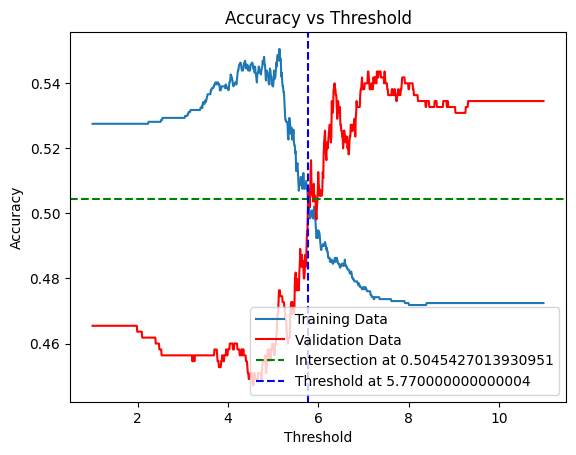

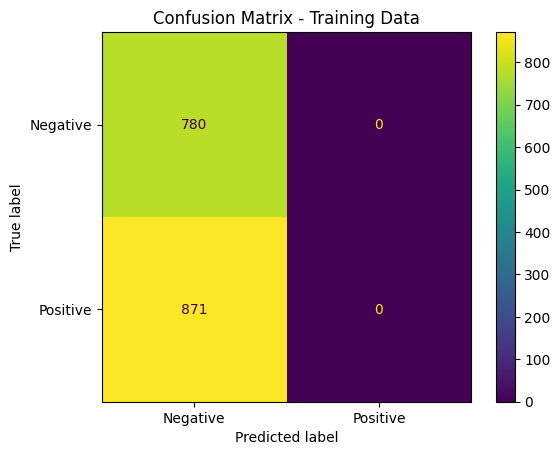

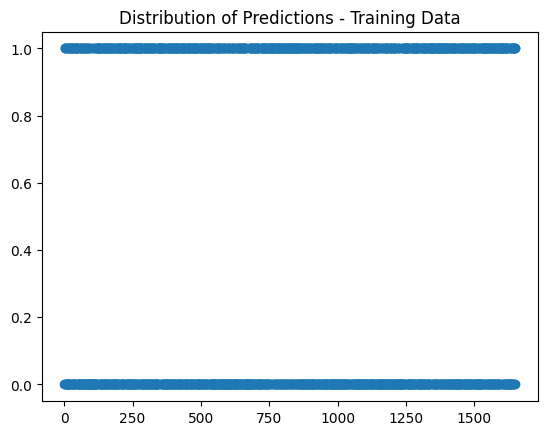

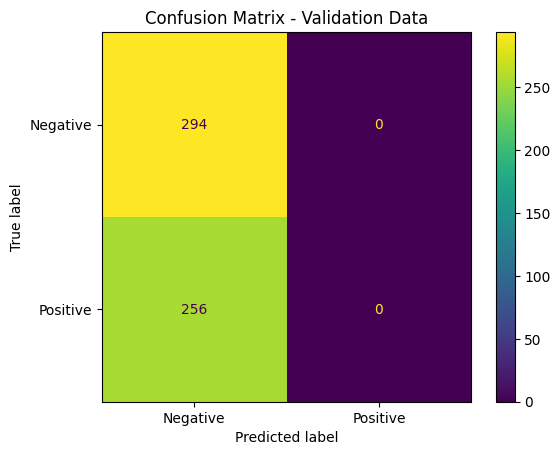

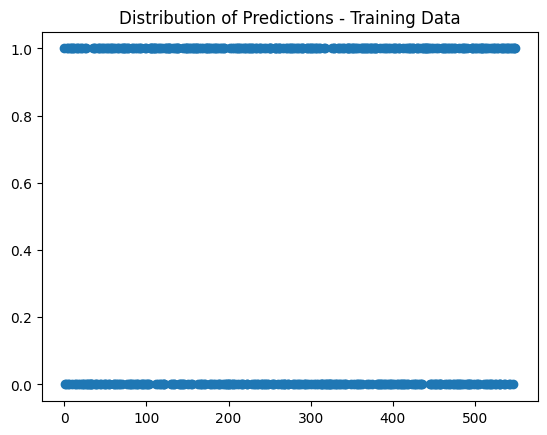

In [68]:
def training_data(model_name = ""):
    success = pd.DataFrame(columns=['Threshold', 'Accuracy_train', 'Accuracy_validate'])
    validate_x_imputed = imputer.fit_transform(validate_x)
    
    for _ in np.arange(1, 11, 0.01):
        train_y_pred = model_name.predict_proba(train_x_imputed)[:, 1] > (_ / 10)
        validate_y_pred = model_name.predict_proba(validate_x_imputed)[:, 1] > (_ / 10)
        conf_matrix_train = confusion_matrix(train_y, train_y_pred)
        success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y_pred)}])], ignore_index=True)

    plt.plot(success['Threshold'], success['Accuracy_train'], label='Training Data')
    plt.plot(success['Threshold'], success['Accuracy_validate'], label='Validation Data', color='red')

    # Find the intersection point
    intersection_threshold_y = success.loc[(success['Accuracy_train'] - success['Accuracy_validate']).abs().idxmin(), 'Accuracy_train']
    plt.axhline(y=intersection_threshold_y, color='green', linestyle='--', label=f'Intersection at {intersection_threshold_y}')

    # Plot another vertical line at the threshold where the accuracy difference is minimized
    intersection_threshold_x = success.loc[(success['Accuracy_train'] - success['Accuracy_validate']).abs().idxmin(), 'Threshold']
    plt.axvline(x=intersection_threshold_x, color='blue', linestyle='--', label=f'Threshold at {intersection_threshold_x}')

    plt.xlabel('Threshold')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy vs Threshold')
    plt.show()

    probabilities = intersection_threshold_x

    train_y_pred = model_name.predict_proba(train_x_imputed)[:, 1] > probabilities

    # Generate the confusion matrix for training data
    conf_matrix_train = confusion_matrix(train_y, train_y_pred)

    # Display the confusion matrix with labels for training data
    disp_train = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_train, display_labels=['Negative', 'Positive'])
    disp_train.plot()
    plt.title('Confusion Matrix - Training Data')
    plt.show()

    equal = equal_data(train_y, train_y_pred)
    plt.scatter(range(len(equal)), equal)
    plt.title('Distribution of Predictions - Training Data')
    plt.show()

    # Predict on the validation data
    validate_y_pred = model_name.predict_proba(validate_x_imputed)[:, 1] > probabilities

    # Generate the confusion matrix for validation data
    conf_matrix_validate = confusion_matrix(validate_y, validate_y_pred)

    # Display the confusion matrix with labels for validation data
    disp_validate = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_validate, display_labels=['Negative', 'Positive'])
    disp_validate.plot()
    plt.title('Confusion Matrix - Validation Data')
    plt.show()

    equal = equal_data(validate_y, validate_y_pred)
    plt.scatter(range(len(equal)), equal)
    plt.title('Distribution of Predictions - Training Data')
    plt.show()

    
training_data(log_reg)

C:\Users\isaac\AppData\Local\Temp\ipykernel_5332\2215603088.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y_pred)}])], ignore_index=True)


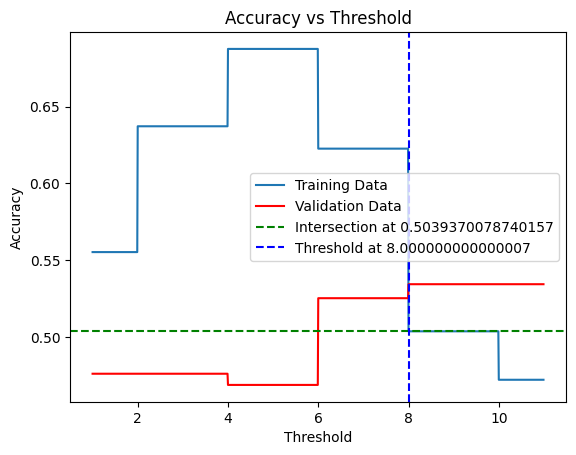

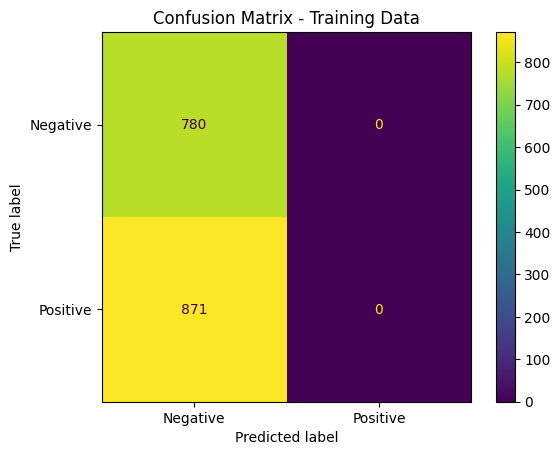

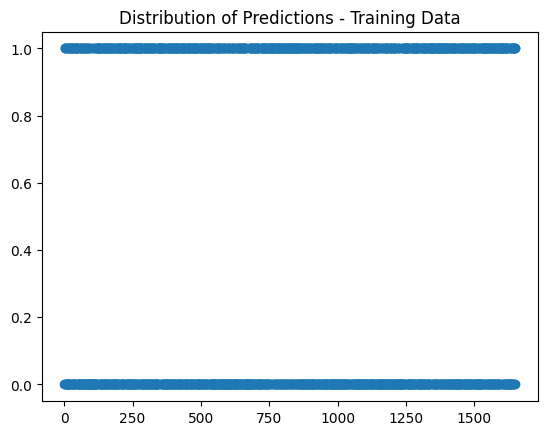

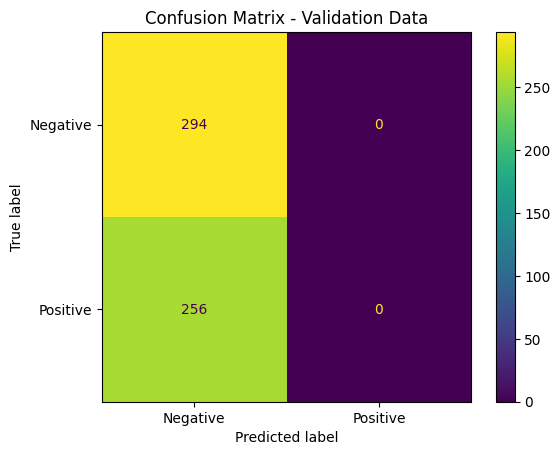

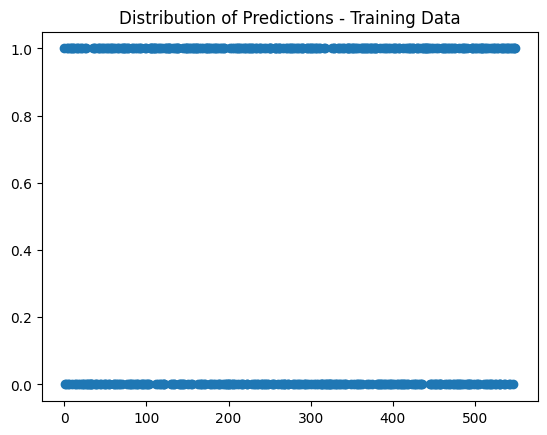

In [69]:
training_data(knn)

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\isaac\AppData\Local\Temp\ipykernel_5332\2215603088.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y

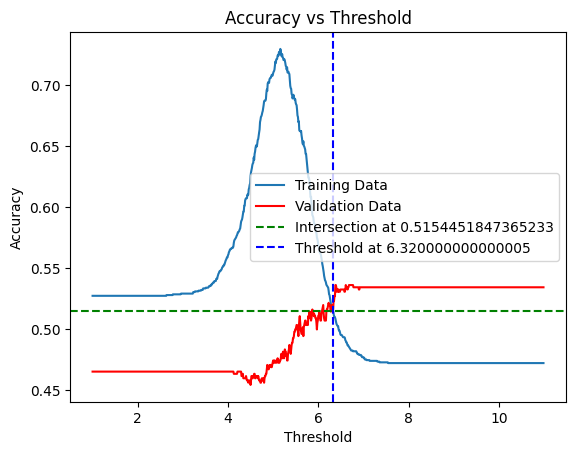

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


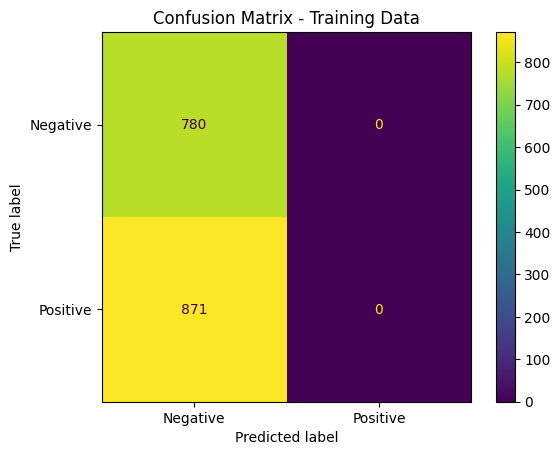

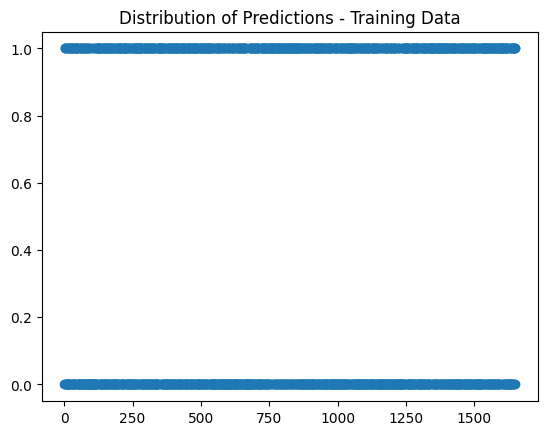

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


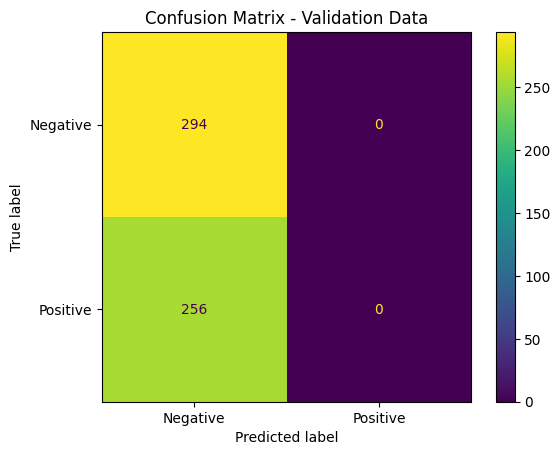

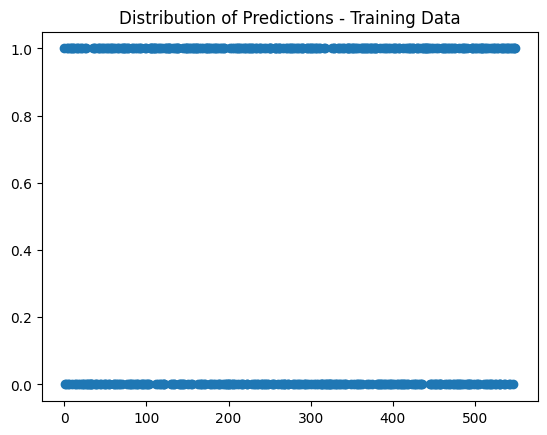

In [72]:
training_data(rf_classifier)

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(
C:\Users\isaac\AppData\Local\Temp\ipykernel_5332\2215603088.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y

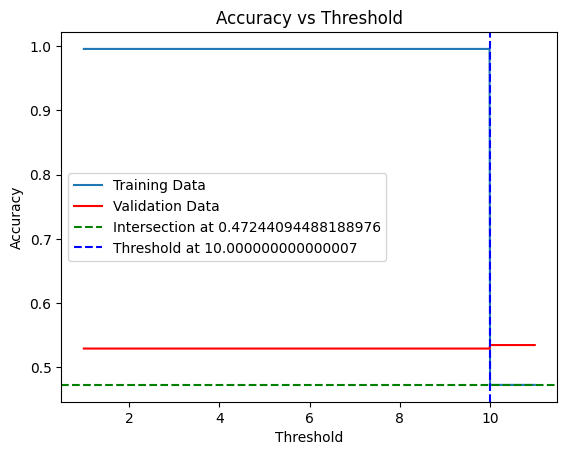

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


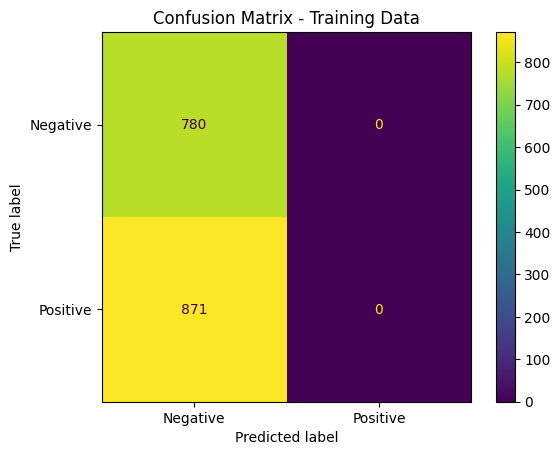

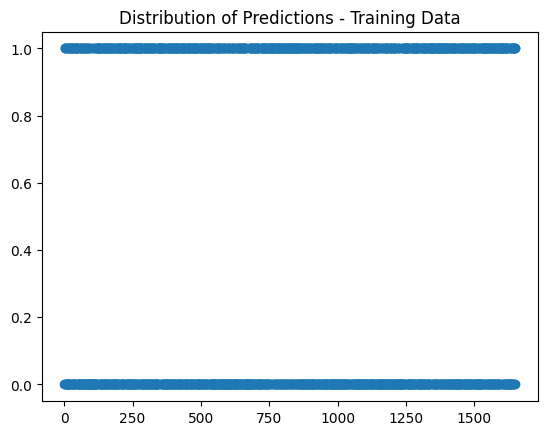

c:\Users\isaac\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


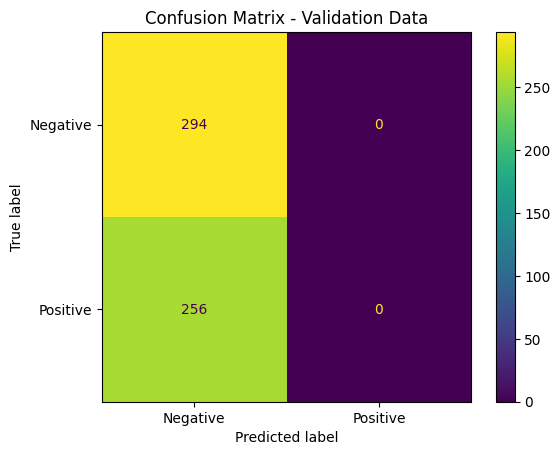

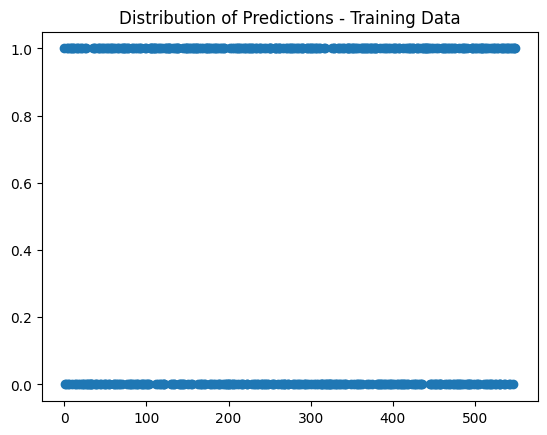

In [73]:
training_data(dt_classifier)

C:\Users\isaac\AppData\Local\Temp\ipykernel_5332\2215603088.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  success = pd.concat([success, pd.DataFrame([{'Threshold': _, 'Accuracy_train': accuracy_score(train_y, train_y_pred), "Accuracy_validate": accuracy_score(validate_y, validate_y_pred)}])], ignore_index=True)


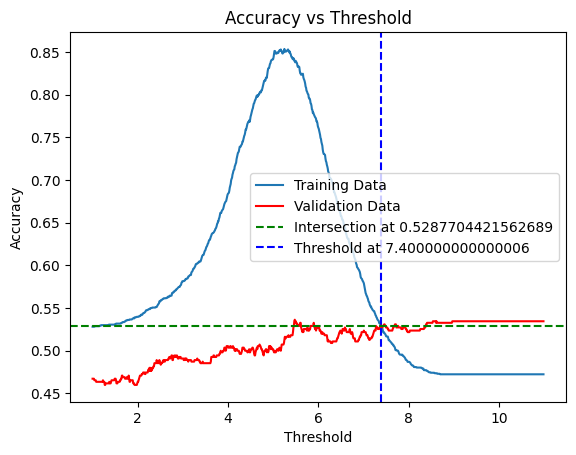

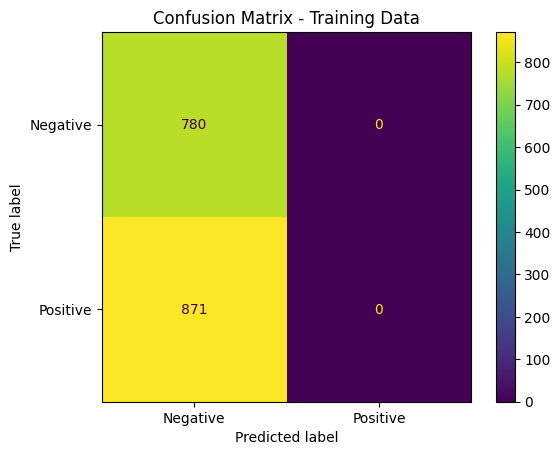

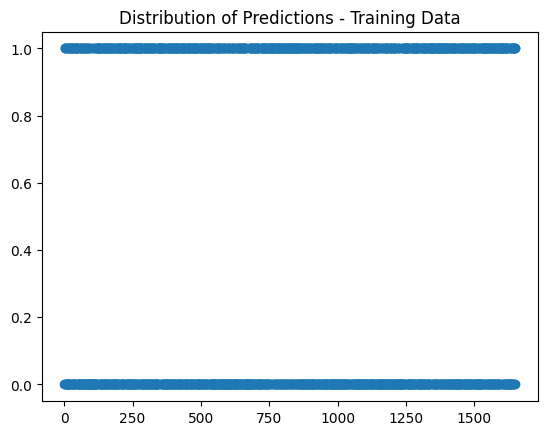

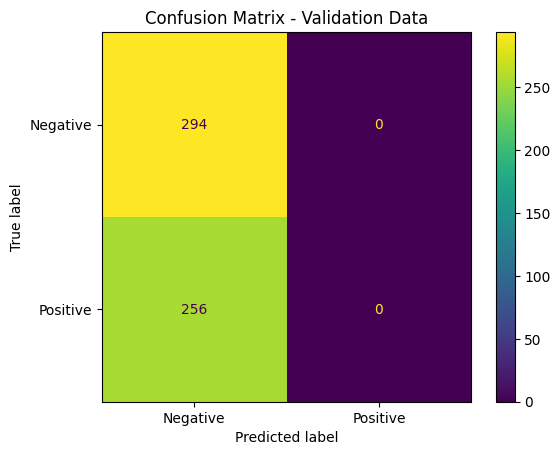

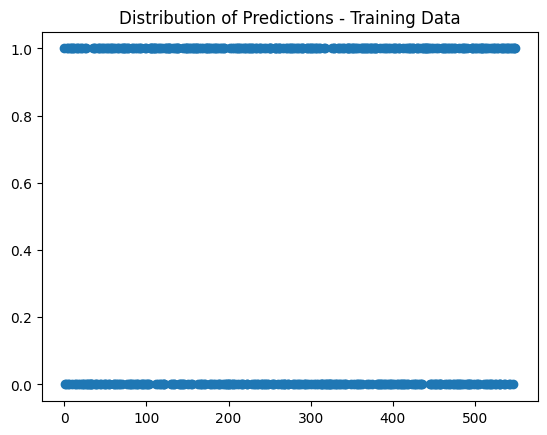

In [74]:
training_data(gb_classifier)